IMPORTS

In [1]:
import importlib
import sys

# Remove the module from cache if it exists
if 'utils2' in sys.modules:
    del sys.modules['utils2']

from utils2 import GeometryOperations

import ee
import pandas as pd
import pyproj
import geopandas as gpd
from shapely.geometry import Polygon

ee.Authenticate()
ee.Initialize(project='dse-staff')

PROTECTED_AREAS = ee.FeatureCollection("WCMC/WDPA/202106/polygons")
ECOREGIONS = gpd.read_file("../data/Ecoregions2017/Ecoregions2017.shp")
WATER_MASK = ee.Image("JRC/GSW1_4/GlobalSurfaceWater").select('occurrence')
HM_IMAGE = ee.ImageCollection('CSP/HM/GlobalHumanModification').mean()
MODIS = ee.ImageCollection('MODIS/006/MOD09A1')

geom_ops = GeometryOperations()

/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:209: DeprecationWarning: 

Attention required for MODIS/006/MOD09A1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD09A1

  warnings.warn(warning, category=DeprecationWarning)


In [ ]:
filtered_polygon = PROTECTED_AREAS.map(geom_ops.set_geometry_type) \
    .filter(geom_ops.get_pa_filter("Polygon")) \
    .map(geom_ops.get_biome) #6358

In [ ]:
wdpa_pids_ee = filtered_polygon.aggregate_array('WDPA_PID')
wdpaids = wdpa_pids_ee.getInfo()
len(wdpaids) 

In [ ]:
task = ee.batch.Export.table.toDrive(
    collection=filtered_polygon,
    description='WDPA_filtered_polygons',
    fileFormat='SHP'
)
task.start()

In [2]:
target_crs = "ESRI:54009"
wdpa = gpd.read_file('../data/WDPA_filtered_polygons.geojson').to_crs(target_crs)
len(wdpa) #6358

6358

In [3]:
# Fill holes smaller than 1500m x 1500m

filled = geom_ops.fill_holes(wdpa, max_hole_area=2250000)  # 1500m * 1500m = 2250000 sq meters
print(f"Number of polygons after filling holes: {len(filled)}") #6358
print(f"Original polygon count: {len(wdpa)}") #6358

Number of polygons after filling holes: 6358
Original polygon count: 6358


In [ ]:
# Find overlap groups
overlap_groups = geom_ops.find_overlap_groups(wdpa, overlap_threshold=90)

# Select best row from each group and create new dataset
selected_rows = []
for group_indices in overlap_groups:
    if len(group_indices) == 1:
        # Single geometry, keep as is
        selected_rows.append(wdpa.loc[group_indices[0]])
    else:
        # Multiple overlapping geometries, select best one
        group_df = wdpa.loc[group_indices]
        best_row = geom_ops.get_min_year_from_group(group_df)
        selected_rows.append(best_row)
        print(f"Overlap group of {len(group_indices)} geometries - selected WDPA_PID: {best_row['WDPA_PID']}")

# Create new GeoDataFrame with selected rows
deduped_overlaps = gpd.GeoDataFrame(selected_rows, crs=wdpa.crs)

print(f"Original count: {len(wdpa)}") #6358
print(f"After removing >90% overlaps: {len(deduped_overlaps)}") #5629
print(f"Removed {len(wdpa) - len(deduped_overlaps)} overlapping geometries") #729

Finding overlap groups with >90% overlap...
Overlap group of 2 geometries - selected WDPA_PID: 31756
Overlap group of 4 geometries - selected WDPA_PID: 196219
Overlap group of 2 geometries - selected WDPA_PID: 20673
Overlap group of 3 geometries - selected WDPA_PID: 20938
Overlap group of 4 geometries - selected WDPA_PID: 20943
Overlap group of 4 geometries - selected WDPA_PID: 349468
Overlap group of 2 geometries - selected WDPA_PID: 143012
Overlap group of 2 geometries - selected WDPA_PID: 1338
Overlap group of 2 geometries - selected WDPA_PID: 5783
Overlap group of 2 geometries - selected WDPA_PID: 389012
Overlap group of 2 geometries - selected WDPA_PID: 860
Overlap group of 2 geometries - selected WDPA_PID: 555538220
Overlap group of 3 geometries - selected WDPA_PID: 555538217
Overlap group of 3 geometries - selected WDPA_PID: 555538219
Overlap group of 2 geometries - selected WDPA_PID: 555523906
Overlap group of 2 geometries - selected WDPA_PID: 555588874
Overlap group of 2 geome

In [ ]:
# Check for duplicate ORIG_NAME next
print("Checking for duplicate ORIG_NAME...")
name_duplicates = deduped_overlaps['ORIG_NAME'].duplicated().sum()
print(f"Duplicate ORIG_NAME: {name_duplicates}") #60

Checking for duplicate WDPA_PIDs...
Duplicate ORIG_NAME: 60


In [ ]:
# Group by ORIG_NAME and apply the function
grouped = deduped_overlaps.groupby('ORIG_NAME').apply(lambda x: geom_ops.get_min_year_from_group(x)).reset_index(drop=True)

# Now dissolve the geometries while keeping the selected attributes
dissolved = grouped.dissolve(by='ORIG_NAME', as_index=False)
print(f"Number of polygons after dissolving by ORIG_NAME: {len(dissolved)}") #5569

/tmp/ipykernel_99273/725220010.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = deduped_overlaps.groupby('ORIG_NAME').apply(lambda x: geom_ops.get_min_year_from_group(x)).reset_index(drop=True)


Number of polygons after dissolving by ORIG_NAME: 5569


After deduping, finish filtering out narrow PAs

In [13]:
# Remove narrow polygons based on perimeter-to-area ratio
# Recalculate area per geometry 
dissolved["AREA_DISSOLVED"] = dissolved.geometry.area
dissolved["PA_DEF"] = dissolved["PA_DEF"].astype(float)
dissolved["PERIMETER"] = dissolved.geometry.length  # length in CRS units
dissolved["PA_RATIO"]  = dissolved["PERIMETER"] / dissolved["AREA_DISSOLVED"]

In [14]:
q75 = dissolved["PA_RATIO"].quantile(0.75)
check = dissolved[dissolved["PA_RATIO"] >= q75]
check.to_file("../data/q75.shp")

/tmp/ipykernel_99273/3493266781.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  check.to_file("../data/q75.shp")
/usr/local/lib/python3.10/dist-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'geometry_type' to 'geometry_t'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'AREA_DISSOLVED' to 'AREA_DISSO'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 555703558 of field WDPAID of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Val

In [17]:
q90 = dissolved["PA_RATIO"].quantile(0.90)
check = dissolved[dissolved["PA_RATIO"] >= q90]
check.to_file("../data/q90.shp")

/tmp/ipykernel_99273/2154753767.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  check.to_file("../data/q90.shp")
/usr/local/lib/python3.10/dist-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'geometry_type' to 'geometry_t'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'AREA_DISSOLVED' to 'AREA_DISSO'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 219558573.96811527 of field AREA_DISSO of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: Runtim

In [ ]:
wdpa_final = dissolved[dissolved["PA_RATIO"] < q75]
len(wdpa_final['WDPA_PID']) # 4176

4176

Critical PA-ratio for 5km buffer: 0.0002
Q75 threshold: 0.0003 (removes polygons ABOVE this)
Q90 threshold: 0.00055 (removes polygons ABOVE this)

Q75 is MORE conservative (removes more polygons)
Q90 is LESS conservative (removes fewer polygons)

Recommendation: Use Q75 (0.0003)
Reason: Closer to critical threshold, ensures buffer safety


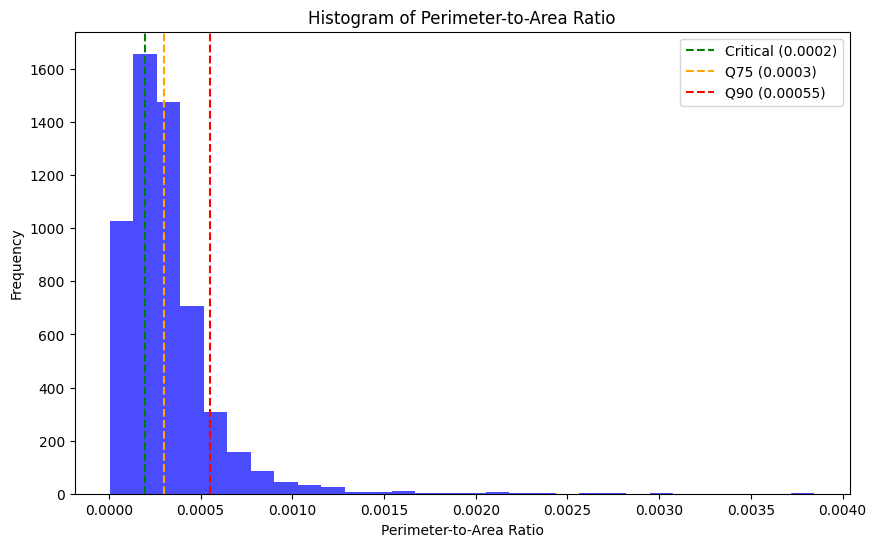

In [ ]:

# For a 5km buffer, we need polygons where the "width" is at least 10km
# The critical case is a rectangle where width = 10km
# For a rectangle: perimeter = 2*(length + width), area = length * width
# PA-ratio = perimeter/area = 2*(length + width)/(length * width)

# At the critical width of 10km (10,000m), as length approaches infinity:
# PA-ratio approaches 2/width = 2/10,000 = 0.0002

critical_pa_ratio = 0.0002  # Critical threshold for 5km buffer
q75_actual = 0.0003
q90_actual = 0.00055

print(f"Critical PA-ratio for 5km buffer: {critical_pa_ratio}")
print(f"Q75 threshold: {q75_actual} (removes polygons ABOVE this)")
print(f"Q90 threshold: {q90_actual} (removes polygons ABOVE this)")

print(f"\nQ75 is MORE conservative (removes more polygons)")
print(f"Q90 is LESS conservative (removes fewer polygons)")

print(f"\nRecommendation: Use Q75 ({q75_actual})")
print(f"Reason: Closer to critical threshold, ensures buffer safety")

# Updated histogram with both thresholds
plt.figure(figsize=(10, 6))
plt.hist(dissolved["PA_RATIO"], bins=30, color='blue', alpha=0.7)
plt.axvline(x=critical_pa_ratio, color='green', linestyle='--', label=f'Critical (0.0002)')
plt.axvline(x=q75_actual, color='orange', linestyle='--', label=f'Q75 (0.0003)')
plt.axvline(x=q90_actual, color='red', linestyle='--', label=f'Q90 (0.00055)')
plt.title("Histogram of Perimeter-to-Area Ratio")
plt.xlabel("Perimeter-to-Area Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [24]:
wdpa_final.to_file("../data/wdpa_final.shp")

/tmp/ipykernel_99273/1152744819.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  wdpa_final.to_file("../data/wdpa_final.shp")
/usr/local/lib/python3.10/dist-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'geometry_type' to 'geometry_t'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'AREA_DISSOLVED' to 'AREA_DISSO'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 555703554 of field WDPAID of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: Runtime

CREATE ZONES

In [25]:
wdpa_final = gpd.read_file("../data/wdpa_final.shp")

In [ ]:
len(wdpa_final)  # 4176

4176

In [ ]:
zones_list = []

for idx, park in wdpa_final.iterrows():
    geom = park.geometry
    
    # Outer zones (rings extending outward from park boundary)
    center = geom.buffer(1000).difference(geom.buffer(-1000))  # -1 to +1km 
    outer = geom.buffer(3000).difference(geom.buffer(1000))    # +1 to +3km
    far_outer = geom.buffer(5000).difference(geom.buffer(3000)) # +3 to +5km
    
    # Inner zones (rings extending inward from park boundary)
    inner = geom.buffer(-1000).difference(geom.buffer(-3000))   # -1 to -3km (ring inside park)
    far_inner = geom.buffer(-3000).difference(geom.buffer(-5000)) # -3 to -5km (ring inside park)

    base_props = {col: park[col] for col in park.index if col not in ['geometry', 'geometry_t']}
    
    zones_list.extend([
        {**base_props, 'zone': '-1_1km', 'geometry': center},
        {**base_props, 'zone': '1_3km', 'geometry': outer},
        {**base_props, 'zone': '3_5km', 'geometry': far_outer},
        {**base_props, 'zone': '-1_-3km', 'geometry': inner},
        {**base_props, 'zone': '-3_-5km', 'geometry': far_inner}
    ])

zones = gpd.GeoDataFrame(zones_list, crs=wdpa_final.crs)
zones.to_file('/workspace/data/zones/zones.shp', driver='ESRI Shapefile')

# Export to GEE assets
import subprocess
subprocess.run([
    'earthengine', 'upload', 'table', 
    '--asset_id=projects/dse-staff/assets/zones',
    '/workspace/data/zones/zones.shp'
], check=True)
print("Zones uploaded to GEE assets: projects/dse-staff/assets/zones")

In [ ]:
import time 

# Simple and reliable spatial relationship check
print("\nAnalyzing spatial relationships (simple method)...")
start_time = time.time()

shares_border = []
for idx, park in deduped.iterrows():
    if idx % 500 == 0:
        print(f"Processing park {idx}/{len(deduped)}")
    
    current_wdpa_pid = park['WDPA_PID']
    
    # Check against all other parks (brute force but reliable)
    has_relationship = False
    for other_idx, other_park in deduped.iterrows():
        other_wdpa_pid = other_park['WDPA_PID']
        
        # Only check different WDPA_PIDs
        if (other_idx != idx and 
            current_wdpa_pid != other_wdpa_pid and 
            park.geometry.intersects(other_park.geometry)):
            has_relationship = True
            break
    
    shares_border.append(has_relationship)

deduped['SHARED_BORDER'] = shares_border

elapsed = time.time() - start_time
print(f"Completed in {elapsed:.1f} seconds")
print(f"Parks with spatial relationships: {sum(shares_border)}")
print(f"Parks without spatial relationships: {len(shares_border) - sum(shares_border)}")

RUN ANALYSIS

In [ ]:
zones = ee.FeatureCollection('projects/dse-staff/assets/zones')

In [ ]:
hm_masked = HM_IMAGE.updateMask(WATER_MASK)

hm_results = hm_masked.reduceRegions(
    collection=zones,
    reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True).combine(ee.Reducer.median(), '', True)
        .setOutputs(['hm_mean', 'hm_stddev', 'hm_median']),
    scale=500,
    tileScale=8
)

In [ ]:
# Process multiple years of MODIS gradient data with task queue management
import time

years = list(range(2001, 2021)) 
max_concurrent_tasks = 10
submitted_tasks = []

def check_task_status():
    """Check status of submitted tasks and remove completed ones"""
    global submitted_tasks
    active_tasks = []
    for task_obj, year in submitted_tasks:
        task_status = task_obj.status()
        if task_status['state'] in ['COMPLETED', 'FAILED', 'CANCELLED']:
            print(f"Task {year} {task_status['state']}")
        else:
            active_tasks.append((task_obj, year))
    submitted_tasks = active_tasks
    return len(submitted_tasks)

for i, year in enumerate(years):
    # Wait if we have too many active tasks
    while check_task_status() >= max_concurrent_tasks:
        print(f"Waiting... {len(submitted_tasks)} tasks active")
        time.sleep(30)  # Check every 30 seconds
    
    print(f"Processing year {year} ({i+1}/{len(years)})...")
    
    # Get MODIS and calculate NDVI
    modis = MODIS.filterDate(f'{year}-01-01', f'{year}-12-31') \
        .max() \
        .select(['sur_refl_b01', 'sur_refl_b02'])  # Red and NIR bands
    
    # Calculate NDVI
    ndvi = modis.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename('ndvi').select('ndvi')
    
    # Calculate gradient of NDVI
    grad = ndvi.gradient()
    magnitude = grad.expression('sqrt(x*x + y*y)', {'x': grad.select('x'), 'y': grad.select('y')}).rename('gradient_magnitude')
    magnitude_masked = magnitude.updateMask(WATER_MASK)

    # Reduce with explicit CRS and scale matching MODIS
    final_results = magnitude_masked.reduceRegions(
        collection=hm_results,
        reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True).combine(ee.Reducer.median(), '', True)
            .setOutputs(['gradient_mean', 'gradient_stddev', 'gradient_median']),
        scale=500,   
        tileScale=8
    )
    
    # Export results and track task
    export_task = ee.batch.Export.table.toCloudStorage(
        collection=final_results,
        description=f'results_{year}',
        bucket='dse-staff',
        fileNamePrefix=f'protected_areas/results2/results_{year}',
        fileFormat='CSV',
        selectors=['WDPA_PID', 'ORIG_NAME', 'GOV_TYPE', 'OWN_TYPE',
                   'STATUS_YR', 'IUCN_CAT', 'GIS_AREA', 'PA_RATIO', 'BIOME_NAME',
                   'zone', 'hm_mean', 'hm_stddev', 'hm_median', 'gradient_mean', 'gradient_stddev', 'gradient_median']
    )
    export_task.start()
    submitted_tasks.append((export_task, year))
    print(f"Export task started: {export_task.id} for {year}")

# Wait for remaining tasks to complete
print("Waiting for remaining tasks to complete...")
while check_task_status() > 0:
    print(f"Still waiting for {len(submitted_tasks)} tasks...")
    time.sleep(30)

print("All export tasks completed!")

OLD CODE

In [ ]:
# Add biome name to each WDPA polygon based on largest intersection area from dissolved ecoregions

ecoregions = ECOREGIONS.to_crs(target_crs)
biomes = ecoregions.dissolve(by="BIOME_NAME").reset_index()

biomes["geometry"] = biomes.buffer(0)
wdpa["geometry"] = wdpa.buffer(0)

intersections = gpd.overlay(wdpa, biomes, how="intersection")
intersections["area"] = intersections.geometry.area
idx = intersections.groupby("WDPA_PID")["area"].idxmax()
largest_intersections = intersections.loc[idx].copy()

wdpa_with_biome = wdpa.merge(
    largest_intersections[['WDPA_PID', 'BIOME_NAME']], 
    on='WDPA_PID', 
    how='left'
)

print(f"WDPA polygons with assigned biome: {len(wdpa_with_biome)}")
print(wdpa_with_biome.head())

In [ ]:
# Find geometries with ≥90% overlap - ALL PARKS
print("Finding overlapping geometries (≥90%) across ALL parks...")

def calculate_overlap_percentage(geom1, geom2):
    """Calculate what percentage of each geometry overlaps with the other"""
    try:
        intersection = geom1.intersection(geom2)
        if intersection.is_empty:
            return 0, 0
        intersection_area = intersection.area
        overlap_pct_1 = (intersection_area / geom1.area) * 100
        overlap_pct_2 = (intersection_area / geom2.area) * 100
        return overlap_pct_1, overlap_pct_2
    except:
        return 0, 0

# Find all pairs with ≥90% overlap using brute force
overlap_pids = set()
total_comparisons = len(wdpa_final) * (len(wdpa_final) - 1) // 2
comparisons_done = 0

for idx, park in wdpa_final.iterrows():
    if idx % 500 == 0:
        print(f"Processing park {idx}/{len(wdpa_final)} - Found {len(overlap_pids)} overlapping parks so far")
    
    current_geom = park['geometry']
    current_pid = park['WDPA_PID']
    
    for other_idx, other_park in wdpa_final.iterrows():
        if other_idx <= idx:  # Skip already checked pairs and self
            continue
            
        other_pid = other_park['WDPA_PID']
        other_geom = other_park['geometry']
        
        overlap_1, overlap_2 = calculate_overlap_percentage(current_geom, other_geom)
        max_overlap = max(overlap_1, overlap_2)
        
        if max_overlap >= 90:
            overlap_pids.add(current_pid)
            overlap_pids.add(other_pid)
            print(f"Found ≥90% overlap: {current_pid} vs {other_pid}: {max_overlap:.1f}%")

# Get all rows with overlapping geometries
duplicates_df = wdpa_final[wdpa_final['WDPA_PID'].isin(overlap_pids)].copy()

print(f"\nFound {len(duplicates_df)} rows with ≥90% overlapping geometries")

# Add a group ID
duplicates_df['duplicate_group'] = 'overlap_group'

# Export to shapefile
output_path = '/workspace/data/overlap_geometries_all.shp'
duplicates_df.to_file(output_path, driver='ESRI Shapefile')

print(f"Overlapping geometries exported to: {output_path}")
print(f"You can now open this in QGIS to review all parks with ≥90% overlap")

SHARED BORDER

VISUALIZATION

In [ ]:
# Simplified version - just use gsutil and handle errors better
import subprocess
import tempfile
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Simple download with error handling
temp_dir = tempfile.mkdtemp()
try:
    result = subprocess.run(['gsutil', 'ls', 'gs://dse-staff/protected_areas/results/*.csv'], 
                          capture_output=True, text=True, check=True)
    files = result.stdout.strip().split('\n')
    print(f"Found {len(files)} files")
    
    # Download all files
    subprocess.run(['gsutil', '-m', 'cp'] + files + [temp_dir], check=True)
    
    # Load and combine
    all_data = []
    for file in glob.glob(os.path.join(temp_dir, '*.csv')):
        year = int(os.path.basename(file).split('_')[-1].split('.')[0])
        df = pd.read_csv(file)
        df['year'] = year
        all_data.append(df)
    
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df['pid_zone'] = combined_df['WDPA_PID'].astype(str) + '_' + combined_df['zone']
    
    # Plot
    plt.figure(figsize=(15, 8))
    for pid_zone in combined_df['pid_zone'].unique():
        subset = combined_df[combined_df['pid_zone'] == pid_zone].sort_values('year')
        plt.plot(subset['year'], subset['gradient_mean'], alpha=0.7, linewidth=1)
    
    plt.xlabel('Year')
    plt.ylabel('NDVI Gradient Mean')
    plt.title('Timeline of NDVI Gradient by Protected Area and Buffer Zone')
    plt.grid(True, alpha=0.3)
    plt.show()
    
except subprocess.CalledProcessError as e:
    print(f"Error: {e}")
    print("Maybe no files exist yet or gsutil auth issue")